In [1]:
#custome modules
import acquire as a
import prepare
import wrangle as w

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# import standard libraries
import pandas as pd
import re

# import file managers
from os.path import isfile
import pickle

# import json handler
import json

# import language detector
from langdetect import detect

import nltk
import unicodedata
import re

#split
from sklearn.model_selection import train_test_split

#modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/natasharivers/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/natasharivers/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<hr style="border:2px solid black"> </hr>

# Acquire/Prepare

In [2]:
#open json file
jsn= open('data2.json')

In [3]:
#load in jsn
df=json.load(jsn)

In [4]:
#open the jsn
df = w.open_json_data()

In [5]:
#turn into a DF
df = pd.DataFrame(df)

#take a look at the data
df.head()

,repo,language,readme_contents
1,covid19india/covid19india-react,JavaScript,"<p align=""center"">\n<img src=""https://reposito..."
3,tokyo-metropolitan-gov/covid19,Vue,# 東京都 新型コロナウイルス感染症対策サイト\n\n[![production deplo...
4,owid/covid-19-data,Python,# COVID-19 Dataset by _Our World in Data_ \n[!...
6,ieee8023/covid-chestxray-dataset,Jupyter Notebook,\n#### 🛑 Note: please do not claim diagnostic ...
7,geohot/corona,Python,# Reverse engineering the coronavirus (SARS-Co...


In [6]:
#take a look at the df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 612 entries, 1 to 681
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             612 non-null    object
 1   language         612 non-null    object
 2   readme_contents  612 non-null    object
dtypes: object(3)
memory usage: 19.1+ KB


In [7]:
df.shape

(612, 3)

In [8]:
def clean(text):
    '''
    This function is a simplified text cleaning function
    '''
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return re.sub(r"[^a-z0-9\s]", '', text)

In [9]:
#see the count for each language
df.language.value_counts()

#python appears to be the most used language

Python              157
JavaScript          128
Jupyter Notebook     73
HTML                 44
TypeScript           34
R                    26
Dart                 21
Java                 17
Vue                  16
Kotlin               12
PHP                  11
C++                   8
C#                    7
CSS                   7
Go                    7
Swift                 6
Shell                 6
Ruby                  5
TeX                   3
Clojure               2
SCSS                  2
Dockerfile            2
Julia                 2
RMarkdown             1
Roff                  1
Objective-C           1
Pascal                1
Nextflow              1
Nix                   1
Mathematica           1
GAML                  1
Reason                1
C                     1
Stan                  1
Elixir                1
Common Lisp           1
G-code                1
MATLAB                1
F#                    1
Name: language, dtype: int64

In [10]:
#Drop any df duplicates
df = df.drop_duplicates().dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 612 entries, 1 to 681
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             612 non-null    object
 1   language         612 non-null    object
 2   readme_contents  612 non-null    object
dtypes: object(3)
memory usage: 19.1+ KB


In [11]:
#Rename readme_contents column
df = df.rename({'readme_contents':'original'},axis=1)

#Apply functions from prepare script
df['clean'] = df.original.apply(prepare.basic_clean)
df['lemmatized'] = df.clean.apply(prepare.lemmatize)
df['stopwords_removed'] = df.lemmatized.apply(prepare.remove_stopwords)

In [12]:
#take a look at new df
df.head()

,repo,language,original,clean,lemmatized,stopwords_removed
1,covid19india/covid19india-react,JavaScript,"<p align=""center"">\n<img src=""https://reposito...",p aligncenter\nimg srchttpsrepositoryimagesgit...,p aligncenter img srchttpsrepositoryimagesgith...,p aligncenter img srchttpsrepositoryimagesgith...
3,tokyo-metropolitan-gov/covid19,Vue,# 東京都 新型コロナウイルス感染症対策サイト\n\n[![production deplo...,\n\nproduction deployhttpsgithubcomtokyometr...,production deployhttpsgithubcomtokyometropolit...,production deployhttpsgithubcomtokyometropolit...
4,owid/covid-19-data,Python,# COVID-19 Dataset by _Our World in Data_ \n[!...,covid19 dataset by our world in data \nwebsit...,covid19 dataset by our world in data website s...,covid19 dataset world data website shieldsioht...
6,ieee8023/covid-chestxray-dataset,Jupyter Notebook,\n#### 🛑 Note: please do not claim diagnostic ...,\n note please do not claim diagnostic perfor...,note please do not claim diagnostic performanc...,note please claim diagnostic performance model...
7,geohot/corona,Python,# Reverse engineering the coronavirus (SARS-Co...,reverse engineering the coronavirus sarscov2\...,reverse engineering the coronavirus sarscov2 s...,reverse engineering coronavirus sarscov2 start...


In [13]:
#take a look at all python 
df[df.language == 'Python']

,repo,language,original,clean,lemmatized,stopwords_removed
4,owid/covid-19-data,Python,# COVID-19 Dataset by _Our World in Data_ \n[!...,covid19 dataset by our world in data \nwebsit...,covid19 dataset by our world in data website s...,covid19 dataset world data website shieldsioht...
7,geohot/corona,Python,# Reverse engineering the coronavirus (SARS-Co...,reverse engineering the coronavirus sarscov2\...,reverse engineering the coronavirus sarscov2 s...,reverse engineering coronavirus sarscov2 start...
10,ExpDev07/coronavirus-tracker-api,Python,"<h1 align=""center"">\n Coronavirus Tracker A...",h1 aligncenter\n coronavirus tracker api\nh...,h1 aligncenter coronavirus tracker api h1 prov...,h1 aligncenter coronavirus tracker api h1 prov...
16,FoldingAtHome/coronavirus,Python,# Folding@home COVID-19 efforts\n\nThis reposi...,foldinghome covid19 efforts\n\nthis repositor...,foldinghome covid19 effort this repository wil...,foldinghome covid19 effort repository contain ...
17,datasets/covid-19,Python,# COVID-19 dataset\n\nCoronavirus disease 2019...,covid19 dataset\n\ncoronavirus disease 2019 c...,covid19 dataset coronavirus disease 2019 covid...,covid19 dataset coronavirus disease 2019 covid...
...,...,...,...,...,...,...
656,chk2817/covid-19-curves,Python,"# covid-19-curves\n\nHello Everyone,\n\nThanks...",covid19curves\n\nhello everyone\n\nthanks to ...,covid19curves hello everyone thanks to the ope...,covid19curves hello everyone thanks open sourc...
660,MaZderMind/cwa-qr,Python,Python implementation of the Corona-Warn-App (...,python implementation of the coronawarnapp cwa...,python implementation of the coronawarnapp cwa...,python implementation coronawarnapp cwa event ...
671,match4everyone/match4healthcare,Python,# README\n- Copy `backend.prod.env.example` an...,readme\n copy backendprodenvexample and datab...,readme copy backendprodenvexample and database...,readme copy backendprodenvexample databaseprod...
677,LucaAngioloni/fit-COVID19,Python,# fit-COVID19\nEasy model to fit logistic curv...,fitcovid19\neasy model to fit logistic curve ...,fitcovid19 easy model to fit logistic curve to...,fitcovid19 easy model fit logistic curve covid...


In [14]:
#python clean only
python_words = (' '.join(df[df.language == 'Python'].stopwords_removed))
python_words

"covid19 dataset world data website shieldsiohttpsimgshieldsiowebsiteupdowngreenredhttpshieldsiosvghttpsourworldindataorgcoronavirus datahttpsimgshieldsiobadgepublicdatapurplepublicdata open source love svg3httpsbadgesfrapsoftcomosv3opensourcesvgv103httpsgithubcomellerbrockopensourcebadges find data covid19 documentation publicdatapublicdata documentation data complete covid19 datasetpublicdatareadmemd data covid19 vaccinationspublicdatavaccinationsreadmemd data excess mortalitypublicdataexcessmortalityreadmemd development generalscriptsreadmemd development vaccinationsscriptsscriptsvaccinationsreadmemd development vaccination contribution guidelinesscriptsscriptsvaccinationscontributemd development testingscriptsscriptstestingreadmemd reverse engineering coronavirus sarscov2 start coronapycoronapy thoughtballoon background project applies technique reverse engineeringhttpsenwikipediaorgwikireverseengineering understand sarscov2httpsenwikipediaorgwikisevereacuterespiratorysyndromecoron

In [15]:
#clean java only
java_words = (' '.join(df[df.language == 'JavaScript'].stopwords_removed))

#clean Jupyter Notebook only
jupyter_words = (' '.join(df[df.language == 'Jupyter Notebook'].stopwords_removed))

#html clean only
html_words = (' '.join(df[df.language == 'HTML'].stopwords_removed))

#typescript clean only
type_words = (' '.join(df[df.language == 'TypeScript'].stopwords_removed))

#r clean only
r_words = (' '.join(df[df.language == 'R'].stopwords_removed))

#all clean text
all_words = (' '.join(df.stopwords_removed))

<hr style="border:2px solid black"> </hr>

# Explore

In [16]:
all_words.split()

['p',
 'aligncenter',
 'img',
 'srchttpsrepositoryimagesgithubusercontentcom24738651967519080869111ea94810732fb55380b',
 'width100',
 'p',
 'p',
 'aligncenter',
 "here's",
 'data',
 'hrefhttpsapicovid19indiaorgapia',
 'p',
 'setup',
 'yarn',
 'install',
 'yarn',
 'start',
 'contribution',
 'new',
 'contributing',
 'open',
 'source',
 'github',
 'guidehttpsguidesgithubcomactivitiescontributingtoopensource',
 'help',
 'get',
 'started',
 'please',
 'check',
 'contribution',
 'guidecontributingmd',
 'detail',
 'issue',
 'pull',
 'request',
 'work',
 'repository',
 'small',
 'subset',
 'work',
 'put',
 'together',
 'much',
 'larger',
 'pool',
 'voluntary',
 'effort',
 'contributed',
 'generous',
 'people',
 'around',
 'world',
 'reach',
 'u',
 'hellocovid19indiaorg',
 'production',
 'deployhttpsgithubcomtokyometropolitangovcovid19workflowsproduction20deploybadgesvgbranchmasterhttpsgithubcomtokyometropolitangovcovid19actionsqueryworkflow3a22productiondeploy22',
 'ogp',
 'builderhttpsgithubc

In [17]:
#turn all words into a series
#get value count of all words
pd.Series(all_words.split()).value_counts()

#removing stopwords would change this count

data                                                                                                                    3476
covid19                                                                                                                 2417
de                                                                                                                      1845
case                                                                                                                    1738
img                                                                                                                     1581
                                                                                                                        ... 
1419215e420                                                                                                                1
httpsgithubcomcssegisanddatacovid19blobmastercssecovid19datacssecovid19timeseriestimeseriescovid19confirmedglobalcsv       1


In [18]:
#create a series with words split and value counts for each word
python_freq = pd.Series(python_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
jupyter_freq = pd.Series(jupyter_words.split()).value_counts()
html_freq = pd.Series(html_words.split()).value_counts()
type_freq = pd.Series(type_words.split()).value_counts()
r_freq = pd.Series(r_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [19]:
python_freq

data                                                                    839
covid19                                                                 541
model                                                                   444
python                                                                  409
de                                                                      374
                                                                       ... 
scotianovascotia                                                          1
fhir2datasetfhirrulesgetter                                               1
srchttpsgithubcomaritraroysocialiconsblobmastertwittericonpngrawtrue      1
modelsmasknet                                                             1
fraunhofergesellschaft                                                    1
Length: 17026, dtype: int64

In [20]:
#combine all frequency into single Series
word_counts = pd.concat([python_freq, java_freq, jupyter_freq, html_freq, type_freq, r_freq, all_freq], axis=1).fillna(0).astype(int)

#word count for each language type
word_counts.columns = ['python', 'java', 'jupyter', 'html', 'typescript', 'r', 'all']

In [21]:
#sorted by most common to most common in 'all' 
word_counts.sort_values('all', ascending=False).head(20)

,python,java,jupyter,html,typescript,r,all
data,839,696,588,338,114,333,3476
covid19,541,739,431,253,46,119,2417
de,374,137,669,57,18,61,1845
case,300,325,214,503,22,122,1738
img,263,177,97,21,60,29,1581
run,309,260,79,76,66,22,1090
file,341,158,87,82,39,45,1068
1,243,146,109,212,28,19,1034
project,148,240,116,102,50,21,928
use,267,143,90,61,47,33,900


<hr style="border:1px solid black"> </hr>

# Visualize

In [22]:
#dictate size of figure
plt.rc('figure', figsize=(14, 8))
plt.style.use('seaborn-darkgrid')

Text(0, 0.5, 'Word')

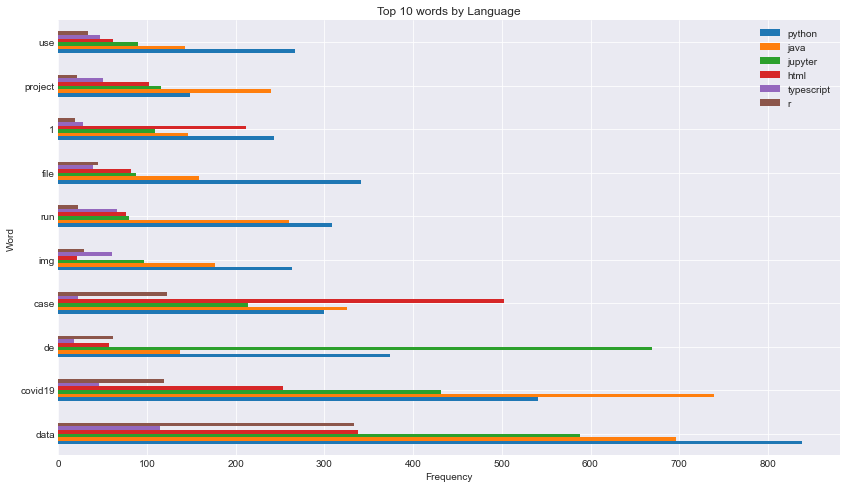

In [23]:
#using 'all' languages
#visualize top 10
word_counts.sort_values('all', ascending=False).head(10)[['python', 'java', 'jupyter', 'html', 'typescript', 'r']].plot.barh()

plt.title('Top 10 words by Language')
plt.xlabel('Frequency')
plt.ylabel('Word')

In [24]:
#visual proportions
#axis=1 in .apply means row by row
word_counts.sort_values(by='all', ascending=False).head(10).apply(lambda row: row/ row['all'],axis=1)

,python,java,jupyter,html,typescript,r,all
data,0.241369,0.200230,0.169160,0.097238,0.032796,0.095800,1.0
covid19,0.223831,0.305751,0.178320,0.104675,0.019032,0.049235,1.0
de,0.202710,0.074255,0.362602,0.030894,0.009756,0.033062,1.0
case,0.172612,0.186997,0.123130,0.289413,0.012658,0.070196,1.0
img,0.166350,0.111954,0.061354,0.013283,0.037951,0.018343,1.0
run,0.283486,0.238532,0.072477,0.069725,0.060550,0.020183,1.0
file,0.319288,0.147940,0.081461,0.076779,0.036517,0.042135,1.0
1,0.235010,0.141199,0.105416,0.205029,0.027079,0.018375,1.0
project,0.159483,0.258621,0.125000,0.109914,0.053879,0.022629,1.0
use,0.296667,0.158889,0.100000,0.067778,0.052222,0.036667,1.0


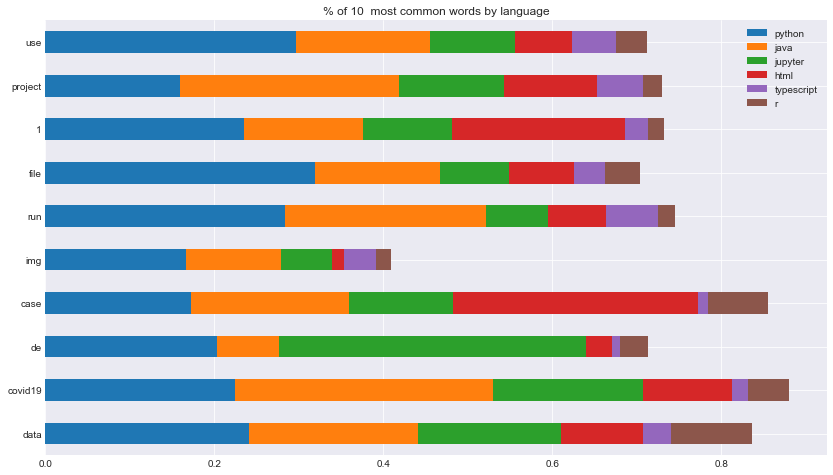

In [25]:
#visualize all languages as percent of 'all'
(word_counts.sort_values(by='all', ascending=False)
 .head(10)
 .apply(lambda row: row/ row['all'],axis=1)
 .drop(columns='all')
 .plot.barh(stacked=True))
plt.title('% of 10  most common words by language')
None

<hr style="border:1px solid black"> </hr>

# n-grams

### Python

In [26]:
#see most common bigrams in python languages
pd.Series(nltk.bigrams(python_words.split())).value_counts()

(pip, install)                    89
(p, aligncenter)                  83
(default, null)                   66
(nbsp, nbsp)                      57
(time, series)                    55
                                  ..
(reciente, 3)                      1
(sequence, sarscov2)               1
(around, 0919)                     1
(pathtobiograkncovid, python3)     1
(test, mednli)                     1
Length: 54494, dtype: int64

### JavaScript

In [27]:
#see most common bigrams in JavaScript language
pd.Series(nltk.bigrams(java_words.split())).value_counts()

(width100px, altbr)                                                                                            113
(td, aligncentera)                                                                                             113
(npm, run)                                                                                                      74
(npm, install)                                                                                                  61
(p, aligncenter)                                                                                                55
                                                                                                              ... 
(report, flulike)                                                                                                1
(mouse, parameter)                                                                                               1
(doe, require)                                                                  

### Jupyter Notebook

In [28]:
#see most common bigrams in JupyterNotebook language
pd.Series(nltk.bigrams(jupyter_words.split())).value_counts()

(tr, tr)                  136
(data, product)            95
(por, el)                  59
(tr, td)                   55
(de, la)                   55
                         ... 
(proved, surprisingly)      1
(ioupng, width500)          1
(program, accurate)         1
(classtgc3ow955td, tr)      1
(make, note)                1
Length: 26111, dtype: int64

### HTML

In [29]:
#see most common bigrams in HTML language
pd.Series(nltk.bigrams(html_words.split())).value_counts()

(new, case)             200
(confirmed, case)        60
(novel, coronavirus)     32
(listrong1, new)         30
(icu, bed)               30
                       ... 
(feedback, active)        1
(testing, measure)        1
(system, hcris)           1
(wa, sourced)             1
(curve, slowly)           1
Length: 24320, dtype: int64

### TypeScript

In [30]:
#see most common bigrams in TypeScript language
pd.Series(nltk.bigrams(type_words.split())).value_counts()

(td, aligncentera)                                  83
(width100px, altbr)                                 83
(titleideas, planning)                              28
(titlecodeatd, td)                                  26
(p, aligncenter)                                    25
                                                    ..
(subbdan, sabinbsubabr)                              1
(part, key)                                          1
(device, know)                                       1
(providedapplicationupdates, institutiondoctors)     1
(srcsrclogopng, width200)                            1
Length: 9571, dtype: int64

### R

In [31]:
#see most common bigrams in R language
pd.Series(nltk.bigrams(r_words.split())).value_counts()

(confirmed, case)                            31
(data, source)                               26
(case, country)                              24
(daily, cumulative)                          18
(public, health)                             16
                                             ..
(brfsscountyinterpolatedcsv, countylevel)     1
(world, fully)                                1
(vintage, csv)                                1
(atendidos, hospitais)                        1
(20201215, added)                             1
Length: 8057, dtype: int64

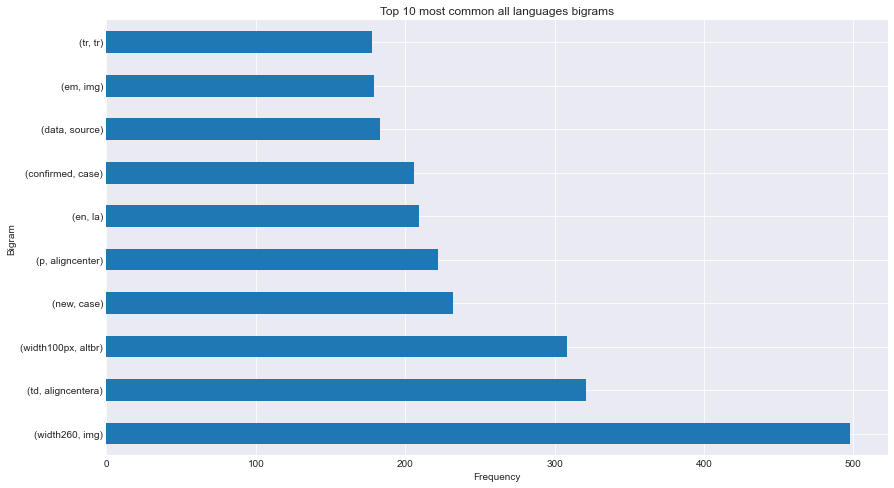

In [32]:
#visualize top ten for all languages
pd.Series(nltk.bigrams(all_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common all languages bigrams')
plt.ylabel('Bigram')
plt.xlabel('Frequency')
None

<hr style="border:1px solid black"> </hr>

# Word Clouds

### Python

(-0.5, 799.5, 599.5, -0.5)

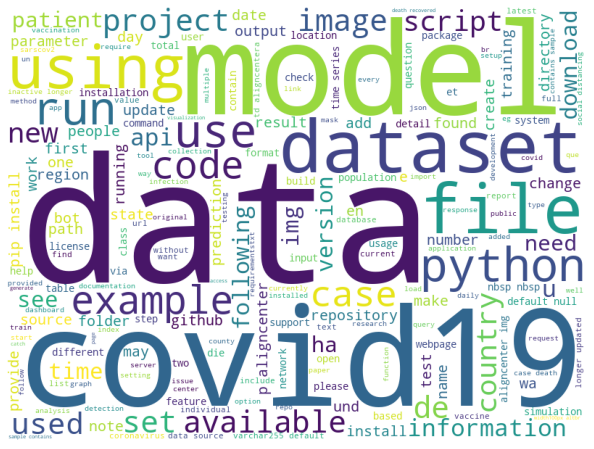

In [33]:
img = WordCloud(background_color='white', width=800, height=600).generate(python_words)
plt.imshow(img)
plt.axis('off')

### JavaScript

(-0.5, 799.5, 599.5, -0.5)

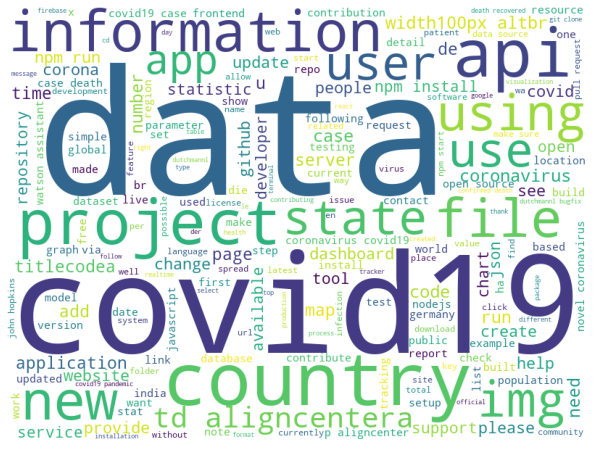

In [34]:
img = WordCloud(background_color='white', width=800, height=600).generate(java_words)
plt.imshow(img)
plt.axis('off')

### Jupyter Notebook

(-0.5, 799.5, 599.5, -0.5)

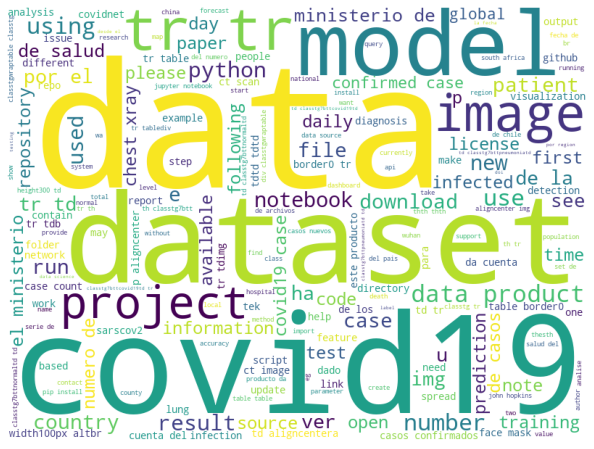

In [35]:
img = WordCloud(background_color='white', width=800, height=600).generate(jupyter_words)
plt.imshow(img)
plt.axis('off')

### HTML

(-0.5, 799.5, 599.5, -0.5)

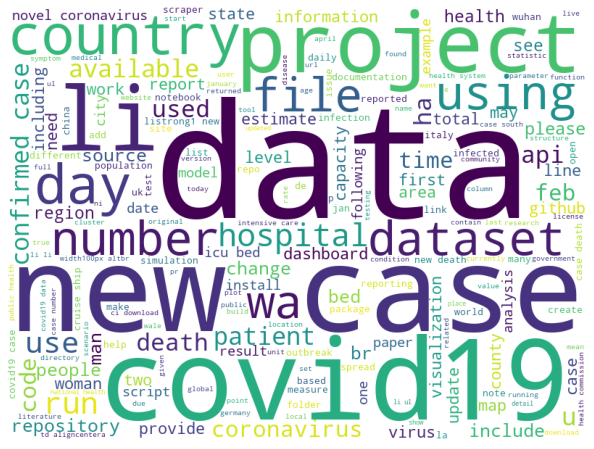

In [36]:
img = WordCloud(background_color='white', width=800, height=600).generate(html_words)
plt.imshow(img)
plt.axis('off')

### TypeScript

(-0.5, 799.5, 599.5, -0.5)

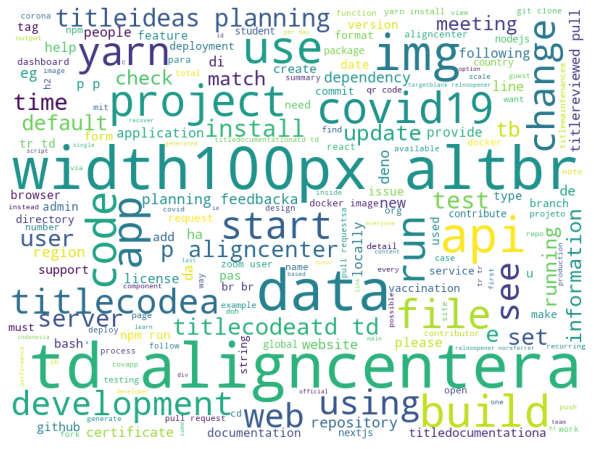

In [37]:
img = WordCloud(background_color='white', width=800, height=600).generate(type_words)
plt.imshow(img)
plt.axis('off')

### R

(-0.5, 799.5, 599.5, -0.5)

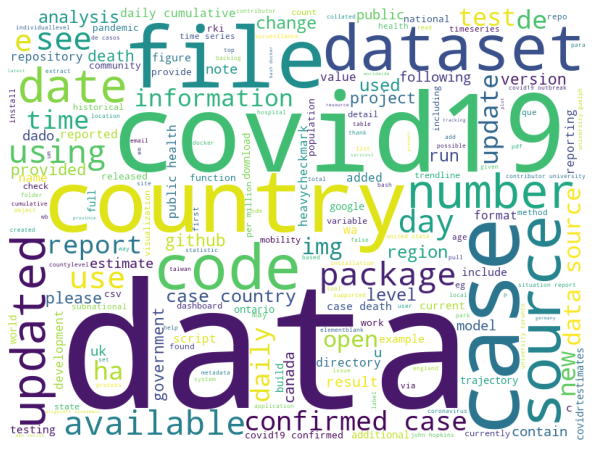

In [38]:
img = WordCloud(background_color='white', width=800, height=600).generate(r_words)
plt.imshow(img)
plt.axis('off')

<hr style="border:2px solid black"> </hr>

# Model

In [39]:
df.head()

,repo,language,original,clean,lemmatized,stopwords_removed
1,covid19india/covid19india-react,JavaScript,"<p align=""center"">\n<img src=""https://reposito...",p aligncenter\nimg srchttpsrepositoryimagesgit...,p aligncenter img srchttpsrepositoryimagesgith...,p aligncenter img srchttpsrepositoryimagesgith...
3,tokyo-metropolitan-gov/covid19,Vue,# 東京都 新型コロナウイルス感染症対策サイト\n\n[![production deplo...,\n\nproduction deployhttpsgithubcomtokyometr...,production deployhttpsgithubcomtokyometropolit...,production deployhttpsgithubcomtokyometropolit...
4,owid/covid-19-data,Python,# COVID-19 Dataset by _Our World in Data_ \n[!...,covid19 dataset by our world in data \nwebsit...,covid19 dataset by our world in data website s...,covid19 dataset world data website shieldsioht...
6,ieee8023/covid-chestxray-dataset,Jupyter Notebook,\n#### 🛑 Note: please do not claim diagnostic ...,\n note please do not claim diagnostic perfor...,note please do not claim diagnostic performanc...,note please claim diagnostic performance model...
7,geohot/corona,Python,# Reverse engineering the coronavirus (SARS-Co...,reverse engineering the coronavirus sarscov2\...,reverse engineering the coronavirus sarscov2 s...,reverse engineering coronavirus sarscov2 start...


In [43]:
X_train, y_train,X_validate, y_validate,X_test, y_test = w.split_data(df)

AttributeError: 'DataFrame' object has no attribute 'target_class'

In [ ]:
#find value counts to find baseline language
y_train.value_counts()

In [ ]:
baseline_accuracy = (y_train == 'Python').mean()
print(f'Baseline accuracy is: {baseline_accuracy:.2%}')

## Decision Tree Model

In [ ]:
#create model - decision tree classifier
tree = DecisionTreeClassifier(max_depth=5, random_state=123)

#fit
tree.fit(X_train, y_train)

#get scores 
print(f'training score for Decision Tree(max_depth =5): {tree.score(X_train, y_train):.2%}')
print(f'test score for Decision Tree(max_depth =5): {tree.score(X_test, y_test):.2%}')

In [ ]:
#create model - decision tree classifier
tree2 = DecisionTreeClassifier(max_depth=3, random_state=123)

#fit the model
tree2.fit(X_train, y_train)

#get scores 
print(f'training score for Decision Tree(max_depth =3): {tree2.score(X_train, y_train):.2%}')
print(f'test score for Decision Tree(max_depth =3): {tree2.score(X_test, y_test):.2%}')

In [ ]:
#create model - decision tree classifier
tree3 = DecisionTreeClassifier(max_depth=10, random_state=123)

#fit the model
tree3.fit(X_train, y_train)

#get scores 
print(f'training score for Decision Tree(max_depth =10): {tree3.score(X_train, y_train):.2%}')
print(f'test score for Decision Tree(max_depth =10): {tree3.score(X_test, y_test):.2%}')

## Logistic Regression

In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.clean)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))
lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# Try on Lemmatized readme instead of cleaned readme

In [ ]:
#term frequency
cv_lem = CountVectorizer()
#identify X
X_lem = cv_lem.fit_transform(df.lemmatized)
#identify target (language)
y_lem = df.language